In [76]:
# !pip install torch
# !pip install torchvision

In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [78]:
# FC VAE Architecture
class FCVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(FCVAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, hidden_dim * 2 * 2)

        self.fc_mu = nn.Linear(hidden_dim * 2 * 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim * 2 * 2, latent_dim)
        
        # Decoder
        self.fc4 = nn.Linear(latent_dim, hidden_dim * 2 * 2)
        self.fc5 = nn.Linear(hidden_dim * 2 * 2, hidden_dim * 2)
        self.fc6 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc7 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        h3 = torch.relu(self.fc3(h2))
        return self.fc_mu(h3), self.fc_logvar(h3)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h4 = torch.relu(self.fc4(z))
        h5 = torch.relu(self.fc5(h4))
        h6 = torch.relu(self.fc6(h5))
        return torch.sigmoid(self.fc7(h6)).view(-1, 3, 32, 32)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [79]:
# Conv VAE Architecture
class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU()
        )

        self.conv_mu = nn.Linear(256 * 2 * 2, latent_dim)
        self.conv_logvar = nn.Linear(256 * 2 * 2, latent_dim)
        self.z = nn.Linear(latent_dim, 256 * 2 * 2)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.conv_mu(x)
        logvar = self.conv_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.z(z)
        x = x.view(-1, 256, 2, 2)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [80]:
# Loss function
def loss_function_cvae(recon_x, x, mu, logvar, beta=1):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + beta * KLD, MSE, KLD

def loss_function_fcvae(recon_x, x, mu, logvar, beta=1):
    BCE = nn.functional.binary_cross_entropy(recon_x.view(-1, 3072), x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD, BCE, KLD

In [81]:
# Training the VAE
def train(model, train_loader, optimizer, epoch, num_epochs, model_name, device):
    model.train()
    train_loss_total = 0
    recon_loss_total = 0
    kld_loss_total = 0
    with tqdm(train_loader, unit='batch', desc=f'Epoch {epoch}', colour='green') as tepoch:
        for batch_idx, (data, _) in enumerate(tepoch):
            if model_name == 'cvae':
                data = data.view(data.size(0), 3, 32, 32).to(device)
            elif model_name == 'fcvae':
                data = data.view(data.size(0), -1).to(device)   
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            if model_name == 'cvae':
                loss_function = loss_function_cvae
            elif model_name == 'fcvae':
                loss_function = loss_function_fcvae
            total_loss, recon_loss, kld_loss = loss_function(recon_batch, data, mu, logvar)
            total_loss.backward()
            train_loss_total += total_loss.item()
            recon_loss_total += recon_loss.item()
            kld_loss_total += kld_loss.item()
            optimizer.step()
            tepoch.set_postfix(
                train_loss=train_loss_total / len(train_loader.dataset),
                recon_loss=recon_loss_total / len(train_loader.dataset),
                kld_loss=kld_loss_total / len(train_loader.dataset)
            )
    print(f'Epoch {epoch}/{num_epochs} train loss: {train_loss_total / len(train_loader.dataset)} mse loss: {recon_loss_total / len(train_loader.dataset)} kld loss: {kld_loss_total / len(train_loader.dataset)}')

In [82]:
num_epochs = 5
lr = 1e-3

In [83]:
# Train the CVAE
transform_cvae = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_dataset_cvae = datasets.CIFAR10('./data/cvae', train=True, download=True, transform=transform_cvae)
train_loader_cvae = torch.utils.data.DataLoader(train_dataset_cvae, batch_size=64, shuffle=True)

cvae = ConvVAE(latent_dim=128).to(device)
optimizer_cvae = optim.Adam(cvae.parameters(), lr=lr)

for epoch in range(1, num_epochs + 1):
    train(cvae, train_loader_cvae, optimizer_cvae, epoch, num_epochs, 'cvae', device)

Files already downloaded and verified


Epoch 1: 100%|██████████| 782/782 [02:04<00:00,  6.29batch/s, kld_loss=20.9, recon_loss=603, train_loss=624]  


Epoch 1/5 train loss: 623.8018245507812 mse loss: 602.8989240234375 kld loss: 20.90290036804199


Epoch 2: 100%|██████████| 782/782 [02:14<00:00,  5.80batch/s, kld_loss=24.4, recon_loss=534, train_loss=558]    


Epoch 2/5 train loss: 558.368303828125 mse loss: 534.00649015625 kld loss: 24.361813154296875


Epoch 3: 100%|██████████| 782/782 [04:06<00:00,  3.18batch/s, kld_loss=26, recon_loss=522, train_loss=548]      


Epoch 3/5 train loss: 548.1753936328125 mse loss: 522.1382748828125 kld loss: 26.037119126586916


Epoch 4: 100%|██████████| 782/782 [03:07<00:00,  4.17batch/s, kld_loss=26.9, recon_loss=517, train_loss=544]    


Epoch 4/5 train loss: 544.3812428027344 mse loss: 517.4527076953125 kld loss: 26.928535563964843


Epoch 5: 100%|██████████| 782/782 [03:15<00:00,  4.00batch/s, kld_loss=27.4, recon_loss=515, train_loss=542]    

Epoch 5/5 train loss: 542.1091625390625 mse loss: 514.6630077734375 kld loss: 27.446154776000977


In [85]:
# Train the FCVAE
transform_fcvae = transforms.Compose([
    transforms.ToTensor()
])

train_dataset_fcvae = datasets.CIFAR10('./data/fcvae', train=True, download=True, transform=transform_fcvae)
train_loader_fcvae = torch.utils.data.DataLoader(train_dataset_fcvae, batch_size=64, shuffle=True)

fcvae = FCVAE(input_dim=3072, hidden_dim=1000, latent_dim=128)
optimizer_fcvae = optim.Adam(fcvae.parameters(), lr=lr)

for epoch in range(1, num_epochs + 1):
    train(fcvae, train_loader_fcvae, optimizer_fcvae, epoch, num_epochs, 'fcvae', device)

Files already downloaded and verified


Epoch 1: 100%|██████████| 782/782 [03:14<00:00,  4.03batch/s, kld_loss=10.2, recon_loss=1.99e+3, train_loss=2e+3]   


Epoch 1/5 train loss: 1995.2266791796876 mse loss: 1985.034792265625 kld loss: 10.191887810158729


Epoch 2: 100%|██████████| 782/782 [07:17<00:00,  1.79batch/s, kld_loss=8.41, recon_loss=1.94e+3, train_loss=1.94e+3]


Epoch 2/5 train loss: 1944.2367011328124 mse loss: 1935.822803359375 kld loss: 8.41389927520752


Epoch 3: 100%|██████████| 782/782 [07:14<00:00,  1.80batch/s, kld_loss=9.68, recon_loss=1.91e+3, train_loss=1.92e+3]


Epoch 3/5 train loss: 1922.29374640625 mse loss: 1912.618051640625 kld loss: 9.675694622802734


Epoch 4: 100%|██████████| 782/782 [06:53<00:00,  1.89batch/s, kld_loss=9.5, recon_loss=1.91e+3, train_loss=1.92e+3] 


Epoch 4/5 train loss: 1917.66363390625 mse loss: 1908.1587378125 kld loss: 9.504893799438477


Epoch 5: 100%|██████████| 782/782 [04:50<00:00,  2.69batch/s, kld_loss=10.8, recon_loss=1.9e+3, train_loss=1.91e+3] 

Epoch 5/5 train loss: 1910.1819956640625 mse loss: 1899.378713828125 kld loss: 10.803280044555665


In [86]:
import matplotlib.pyplot as plt

# Function to generate and display new images
def generate_images(model, num_images, latent_dim):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Turn off gradients for generation
        # Sample random points from the latent space (standard normal distribution)
        z = torch.randn(num_images, latent_dim).to(next(model.parameters()).device)
        # Decode these points to generate images
        generated_images = []
        for i in tqdm(range(num_images), desc='Generating images', unit='image', colour='blue'):
            generated_image = model.decode(z[i:i+1]).cpu()
            generated_images.append(generated_image)
    # Convert the generated images to a single tensor
    generated_images = torch.cat(generated_images, dim=0)

    # Rescale the images to the range [0, 1]
    generated_images = torch.clamp(generated_images, 0, 1)

    # Plot the generated images
    fig, axs = plt.subplots(1, num_images, figsize=(num_images, 1.5))
    for i in range(num_images):
        axs[i].imshow(generated_images[i].numpy().transpose(1, 2, 0))
        axs[i].axis('off')
    plt.show()

Images from FC VAE


Generating images: 100%|██████████| 5/5 [00:00<00:00, 204.17image/s]


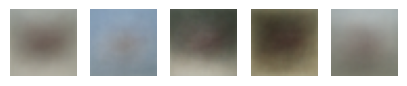

Images from Conv VAE


Generating images: 100%|██████████| 5/5 [00:00<00:00, 203.44image/s]


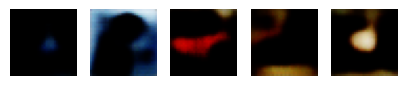

In [88]:
# Assuming you have already trained the model (vae) and it has a latent dimension of 128
print('Images from FC VAE')
generate_images(fcvae, num_images=5, latent_dim=128)

print('Images from Conv VAE')
generate_images(cvae, num_images=5, latent_dim=128)